In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pyvisa           #pip install pyvisa
import time
import sys
import io
import numpy as np
from PIL import Image as PILimage
from IPython.display import Image

ADR = "TCPIP0::192.168.1.30::inst0::INSTR"
rm = pyvisa.ResourceManager()
try:
    scope = rm.open_resource(ADR, timeout=30000)
    print(f"Successfull connected by PyVISA with {ADR}")
except pyvisa.VisaIOError:
    print("Connect fail!")

Successfull connected by PyVISA with TCPIP0::192.168.1.30::inst0::INSTR


In [2]:
Status = scope.query(":*IDN?")
print(Status)

scope_error = scope.query(":SYSTem:ERRor?")
print(scope_error)

RIGOL TECHNOLOGIES,DS2302,DS2A153502286,00.03.06

0,"No error"



In [3]:
image_path = "New_Screen.png"

bmp_bin = scope.query_binary_values(':DISP:DATA?', datatype='B', container=bytes)
img = PILimage.open(io.BytesIO(bmp_bin))
img.save(image_path)

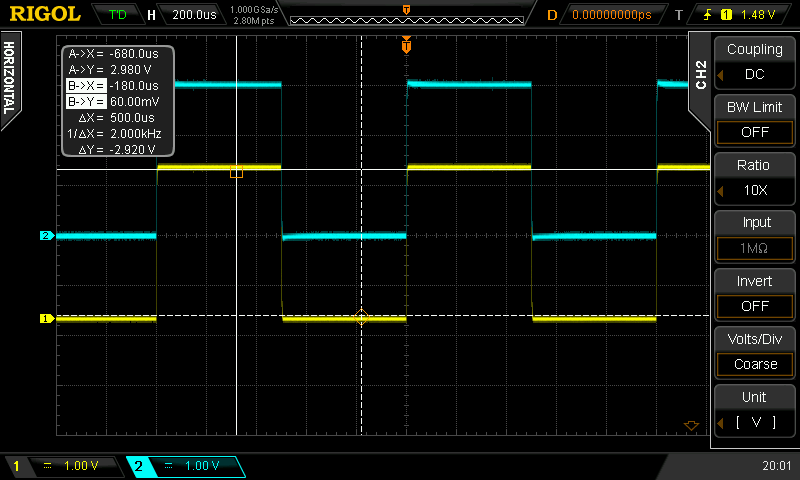

In [4]:
#Show the image
image_path = "New_Screen.png"
# Display the BMP image inline
Image(filename=image_path)

['0', '0', '1400', '1', '2.000000e-06', '-1.400000e-03', '0', '4.000000e-02', '-41', '127\n']
['IDLE', '0\n']


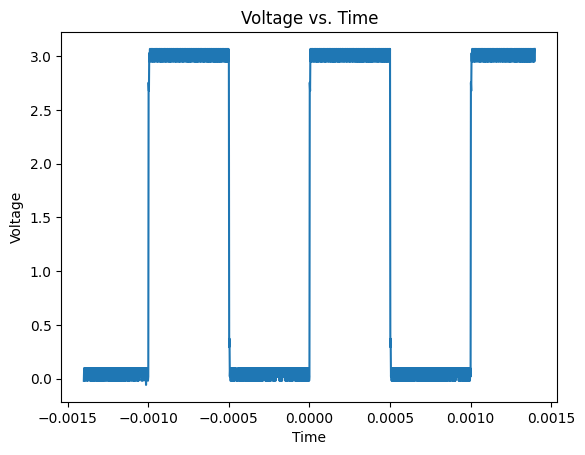

In [7]:
# Get Wavefrom Test

all_data = bytearray()

datapoints = 1400

start_time = time.time()
channel = "CHAN1"
#self.Rigol_ESR(scope)
scope.write(f':WAV:MODE NORM')
scope.write(f':WAV:FORM BYTE')
scope.write(f':WAV:SOUR {channel}')

all_data = scope.query_binary_values(":WAV:DATA?", datatype='B',is_big_endian=True)

# Query waveform parameters
x_increment = scope.query_ascii_values(':WAV:XINC?', converter='f')[0]
x_origin    = scope.query_ascii_values(':WAV:XOR?', converter='f')[0]
x_ref       = scope.query_ascii_values(':WAV:XREF?', converter='f')[0]

y_increment = scope.query_ascii_values(':WAV:YINC?', converter='f')[0]
y_origin    = scope.query_ascii_values(':WAV:YOR?', converter='f')[0]
y_ref       = scope.query_ascii_values(':WAV:YREF?', converter='f')[0]

vscale      = scope.query_ascii_values(f':{channel}:SCALe?', converter='f')[0]
voffset     = scope.query_ascii_values(f':{channel}:OFFSet?', converter='f')[0]

PREamble    = scope.query_ascii_values(f':WAVeform:PREamble?', converter='s')
print(PREamble)


WF_status    = scope.query_ascii_values(f':WAVeform:STATus?', converter='s')
print(WF_status)
# Create time and
time_array = np.arange(len(all_data)) * x_increment + x_origin

# Asolut voltage
voltage_array = (np.array(all_data) - 128) * 10 * vscale / 256 - voffset + y_increment

# Absolt Voltage but with y_origin acc oscilloscope screen
#voltage_array = y_origin + ((np.array(all_data) - 128) * 10 * vscale / 256 - voffset + y_increment) # Old Firmware
voltage_array = 0 + ((np.array(all_data) - 128) * 10 * vscale / 256 - voffset + y_increment) # Old Firmware

# Plot time against voltage
plt.plot(time_array, voltage_array)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Voltage vs. Time')

# Display the plot inline

plt.show()